<a href="https://colab.research.google.com/github/MariaGabrielaAlvesZuppardo/SeriesTemporaisCin/blob/main/Lista_de_Exercicio_Exponential_Smoothing_Seasonal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install yfinance

In [14]:
!pip install pmdarima statsmodels scikit-learn

In [15]:
#!pip install --upgrade scikit-learn pmdarima

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

# Load Data

In [17]:
df = pd.read_excel('LREN3.BALANCO.xls', sheet_name='Dem. Result.', skiprows=range(0, 1))
#rotacionando a tabela
df = df.T
#settando o cabeçalho com os valores da primeira linha
df.columns = df.iloc[0]
#excluindo a primeira linha
df=df.iloc[1:]
#convertando o formato da data e, posteriormente, atualizando o índice.
df.index = pd.to_datetime(df.index,format='%d/%m/%Y')
df = df.rename(columns={'Resultado Bruto':'y'})
df = df[['y']]
df['y'] = df['y'].astype(float)
#definindo a frequencia do índice
df=df.asfreq('Q-DEC')


WARNING *** file size (90809) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


<ipython-input-17-36c2c8c8433c>:14: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  df=df.asfreq('Q-DEC')


# Normalization

<Axes: >

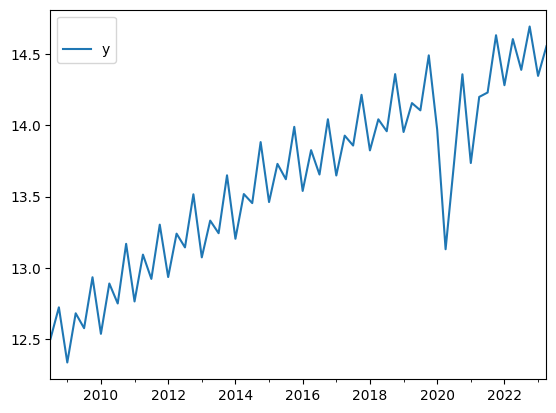

In [60]:
df_log = df.copy()
df_log['y']=np.log(df_log['y'])
df_log.plot()

## Train / Test

In [27]:
size = int(len(df) * 0.7)
train, test = df_log[0:size], df_log[size:len(df)]
h = len(test)
print(train.shape)
print(test.shape)

(42, 1)
(18, 1)


# Modelo Exponential Smoothing

/usr/local/lib/python3.11/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


<Axes: xlabel='ds'>

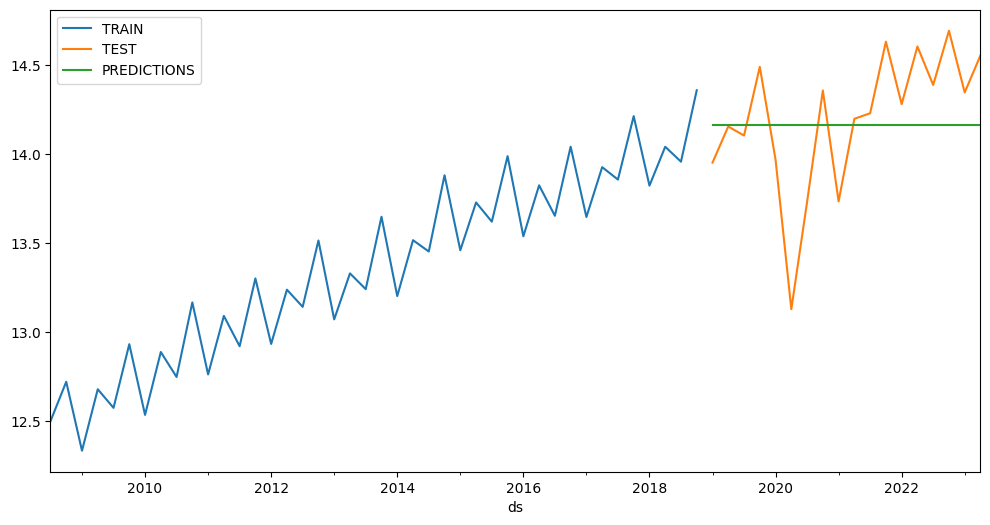

In [40]:
# Simple Exponential Smoothing (SES) for data without trends or seasonality
ses_model = SimpleExpSmoothing(train)
fitted_ses_model = ses_model.fit(smoothing_level=0.5)
ses_predictions = fitted_ses_model.forecast(h)
train['y'].plot(legend=True, label='TRAIN')
test['y'].plot(legend=True, label='TEST')
pd.DataFrame({'ds':test.index, 'y':ses_predictions}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))


# Modelo Holt

<Axes: xlabel='ds'>

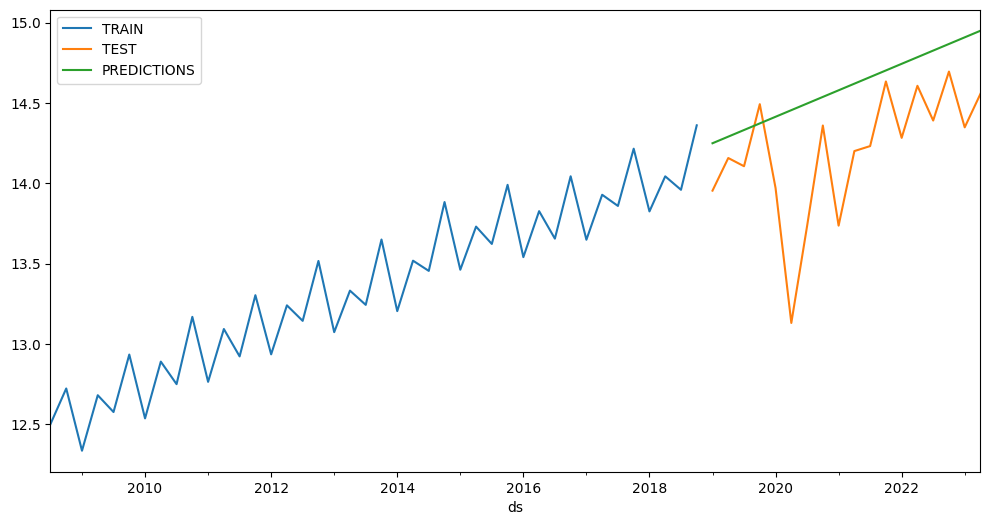

In [59]:
# Double exponential smoothing, also known as Holt's method, extends single exponential smoothing to capture trends in the data.

holt_model = ExponentialSmoothing(train, trend="add", seasonal=None)
fitted_holt_model = holt_model.fit(smoothing_level=0.5)
holt_predictions = fitted_holt_model.forecast(h)
train['y'].plot(legend=True, label='TRAIN')
test['y'].plot(legend=True, label='TEST')
pd.DataFrame({'ds':test.index, 'y':holt_predictions}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))


# Modelo Damped

<Axes: xlabel='ds'>

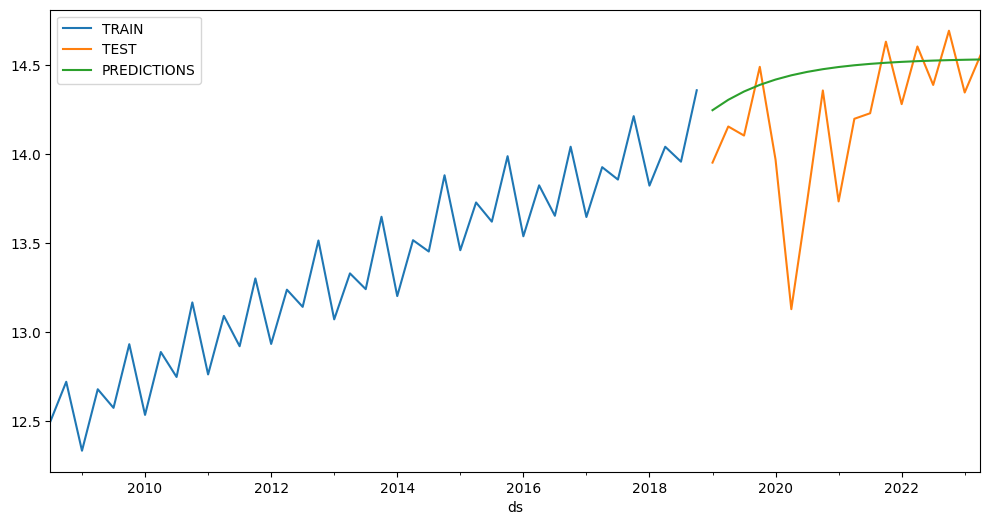

In [54]:
# The Damped Trend model is an extension of Holt’s linear method that introduces a damping parameter (ϕ),
# which gradually reduces the influence of the trend component over time

damped_model = ExponentialSmoothing(train, trend="add", seasonal=None, damped_trend=True)
fitted_damped_model = damped_model.fit(smoothing_level=0.5, smoothing_trend=0.5)
damped_predictions = fitted_damped_model.forecast(h)
train['y'].plot(legend=True, label='TRAIN')
test['y'].plot(legend=True, label='TEST')
pd.DataFrame({'ds':test.index, 'y':damped_predictions}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))


#Modelo Holt-Winters
Triple exponential smoothing (also known as Holt-Winters smoothing) is a smoothing method used to predict time series data with both a trend and seasonal component.

<Axes: xlabel='ds'>

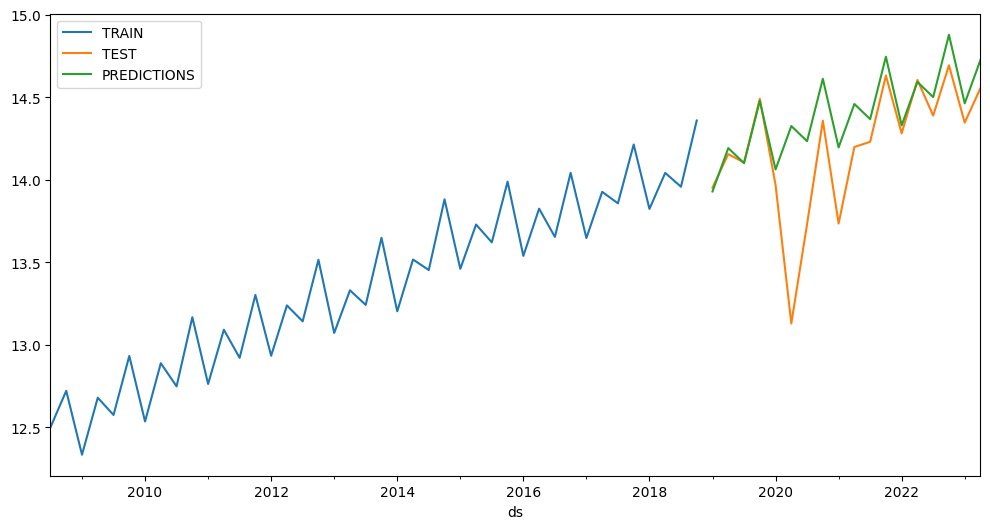

In [57]:


damped_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=4)
fitted_damped_model = damped_model.fit(smoothing_level=0.5, smoothing_trend=0.5)
damped_predictions = fitted_damped_model.forecast(h)
train['y'].plot(legend=True, label='TRAIN')
test['y'].plot(legend=True, label='TEST')
pd.DataFrame({'ds':test.index, 'y':damped_predictions}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))
